In [1]:
%pylab inline
import numpy as n
import os.path
import datetime as dt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import csv

In [199]:
# dt is always in seconds

class Satellite():
    def __init__(self, battery_charge_frac=1.0):
        self.subsystems = {}
        
        # break this out later
        self.battery_capacity_mAh = 20000.0
        self.converter_efficiency = 0.8
        self.charge = self.battery_capacity_mAh * battery_charge_frac
        self.heater_setpoints = {'payload' : 273.15 + 38.0, 'battery' : 273.15 + 30.0 }
        self.temperatures = {'battery' : 273.15 + 30.0, 'structure' : 273.15 + 30.0, 'payload' :  273.15 + 30.0}
        self.q_dots = {'battery' : 0, 'structure' : 0, 'payload' : 0}
        self.solar_shunts = False
        
        # timings
        self.beacon_interval = 60
        self.beacon_duration = 1
        self.passover_interval = 90*60
        self.passover_duration_exp_off = 10*60
        self.passover_duration_exp_on = 1*60
        self.exp_start_time = 7 * 24 * 60 * 60
        self.exp_duration = 2 * 24 * 60 * 60
        
        # power budget? need to fix these numbers
        self.beacon =        {'state': False, 'i': 1.00 ,   'v': 5.0, 'name' : 'beacon'}
        self.passover =      {'state': False, 'i': 1.00 ,   'v': 5.0, 'name' : 'passover'}
        self.exp =           {'state': False, 'i': 0.10 ,   'v': 3.3, 'name' : 'exp_inst'}
        self.batt_heater =   {'state': False, 'i': 0.25 ,   'v': 5.0, 'name' : 'batt_heat'}
        self.pay_heater =    {'state': False, 'i': 0.50 ,   'v': 5.0, 'name' : 'pay_heat'}
        self.bus_const_pwr = {'state': False , 'i': 0.20 ,   'v': 3.3, 'name' : 'bus_const'}
        
        self.loads = [self.exp, self.bus_const_pwr, self.beacon, self.passover, self.batt_heater, self.pay_heater]
        
    
    def set_state(self, t):
        
        # dynamic state variables
        self.batt_heater = self.temperatures['battery'] < self.heater_setpoints['battery']
        self.pay_heater = self.temperatures['payload'] < self.heater_setpoints['payload']
           
        # time based state variables
        self.beacon = t % self.beacon_interval < self.beacon_duration
        self.exp = False #(t < self.exp_start_time + self.exp_duration) and (t > self.beacon_duration)
        
        if self.exp:
            self.passover = t % self.passover_interval < self.passover_duration_exp_on
        else:
            self.passover = t % self.passover_interval < self.passover_duration_exp_off          
        
        if self.passover: self.beacon = False
        
        print (self.passover)
    
    def draw_powers(self, dt=1):
        delta = 0
        for load in self.loads:
            
            if load['state']:
                delta += self.discharge(load['v'], load['i'], dt)
                delta += load['i']
#         print ([(l['name'], l['state']) for l in self.loads])
#         print (delta)
        return delta
    def get_battery_voltage(self):
        # replace this with actual I-V curve of the batteries
        batt_vmax = 4
        batt_vmin = 2.5
        return batt_vmin + (self.charge/(self.battery_capacity_mAh)) * (batt_vmax - batt_vmin)
        
    def charge_from_solar_panel(self, effective_area, dt=1):
        n_cells_per_side = 6.0
        pv_cell_current_mA = 500.0 * n_cells_per_side # 500 is the assumed mA provided by panels in sun
        new_charge = self.charge + effective_area * pv_cell_current_mA * (dt/3600)
        
        self.charge = min(new_charge, self.battery_capacity_mAh)
        if new_charge > self.battery_capacity_mAh:
            self.solar_shunts = True
        
    def discharge(self, voltage_out, current_out, dt=1):
        newcharge = self.charge - ((voltage_out * current_out)/self.get_battery_voltage()) * (dt / 3600.0) * (1/self.converter_efficiency)
        delta = newcharge - self.charge
        #         print (self.charge, newcharge)?
        if newcharge < 0:
            print("Battery Died")
            self.charge = 0
        else: self.charge = newcharge
            
#         return current_out


In [200]:
t_orbit = 92 * 60
dt = 1 # seconds
areas_dict = {}
headers = ['plusX', 'plusY', 'plusZ', 'negX', 'negY', 'negZ']
with open('/home/ali/UTAT/mission-sim/sources/heron_area.csv') as area_csv_file:
    reader = csv.reader(area_csv_file)
    for row in reader:
        if row[0] in headers:
            areas_dict[row[0]] = {'times' : [], 'area' : [], 'intensity' : []}
            current_header = row[0]
        elif row[1] == 'Time':
            continue
        elif row == ['','','','','']:
            break
        else:            
            areas_dict[current_header]['times'].append((row[2]))
#             print('value:',  row[3])
            areas_dict[current_header]['area'].append(n.float32(row[3]))
            areas_dict[current_header]['intensity'].append(n.float32(row[4]))


areas = np.array( n.zeros(int(t_orbit/dt)), [(h, np.float32) for h in headers])
for h in headers: areas[h][:len(areas_dict[h]['area'])] = areas_dict[h]['area']
times = n.array([i*dt for i in range(int(t_orbit/dt))], n.float32)
t_orbit = len(times) * dt
n_pts_per_orbit = len(times)
panels = headers

In [201]:
total_area = []

In [202]:
for row in areas:
    total_area.append((row['plusX'] + row['plusY'] + row['negX'] + row['negY']) / (0.03))

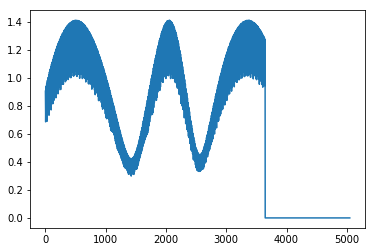

In [220]:
plot(total_area[470:])

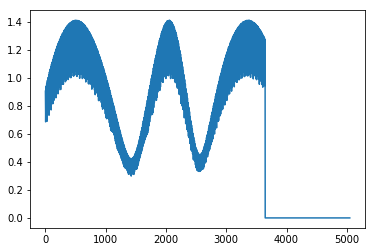

In [222]:
with open('/home/ali/UTAT/mission-sim/heron_area_frac.csv','a') as csvFile:
    writer = csv.writer(csvFile)
    for t in total_area[470:]:
        writer.writerow([t])

read = []

with open('/home/ali/UTAT/mission-sim/heron_area_frac.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        read.append(n.float32(row[0]))

str(1.0)

plot(read)

(0, 3000)

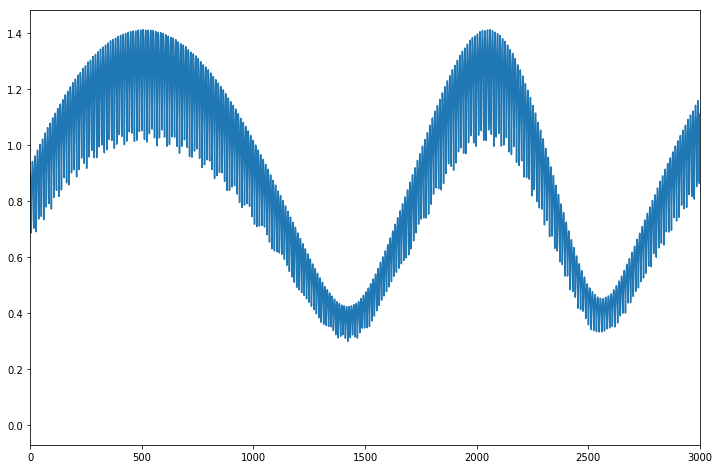

In [225]:
fig = figure(figsize=(12,8))
plot(read)
xlim(0,3000)

In [205]:
heron = Satellite(0.1)

In [206]:
heron.get_battery_voltage()

2.65

In [207]:
n_orbits = 2
n_points = n_orbits * n_pts_per_orbit
t_sim = n_points * dt

In [208]:
batt_voltage = []
discharge = []
power_drawn = []
for i in range(n_points):
    heron.set_state(i)
    discharge.append(heron.draw_powers())
    for panel in panels:
        if i < len(areas[panel]):
            heron.charge_from_solar_panel(areas[panel][i] / 0.03, dt)
    
    batt_voltage.append(heron.get_battery_voltage())

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [209]:
heron.set_state(100)
heron.draw_powers(1)

True


0

In [211]:
len(discharge)

11040

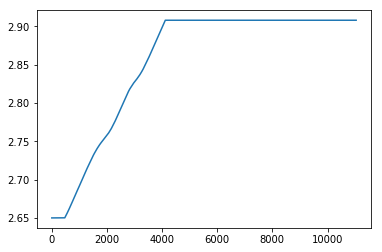

In [213]:
plot(batt_voltage)